In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from  ana_tools import *
import plotly.graph_objects as go


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })



In [3]:
def loaddata(path:str, entry_stop=None, forceit=False):
    parquet_path= path.replace(".root", ".parquet")
    if os.path.isfile(parquet_path) and not forceit:
        print(path, 'loaded parquet')
        df = pl.read_parquet(parquet_path)
        return df
    pid = PIDA(path, entry_stop=entry_stop)
    dfs:pl.DataFrame
    dfv:pl.DataFrame
    df:pl.DataFrame

    dfs = pid.dfsingles
    dfv = pid.dfvector
    dfp = pid.dfplanes

    df = dfs.join(dfv, on=selection_events())
    df = df.join(dfp, on=selection_events())
    df.write_parquet(file=parquet_path)
    
df = loaddata("data/pida.root", entry_stop=None, forceit=False)
# df = loaddata("data/pida_not_limited.root", entry_stop=None, forceit=False)
# df = loaddata("data/pida_before_llhd_not_limited.root", entry_stop=None, forceit=False)
df_lim = loaddata("data/pida_limited.root", entry_stop=None)


data/pida_visen.root loaded parquet
data/pida_limited.root loaded parquet


In [1564]:
xmin = -363.3766
ymin = -607.8299
zmin = -0.876256
xmax = 363.37
ymax = 607.82
zmax = 1393.4
threshold = 10

dftrkg4 = df.with_columns(
    trkIsContained2 = pl.when(
        (pl.col('trkendx') - (xmin+threshold) >= 0) &
        (pl.col('trkendy') - (ymin+threshold) >= 0) &
        (pl.col('trkendz') - (zmin+threshold) >= 0) &
        (pl.col('trkendx') - (xmax-threshold) <= 0) &
        (pl.col('trkendy') - (ymax-threshold) <= 0) &
        (pl.col('trkendz') - (zmax-threshold) <= 0) 
    ).then(True).otherwise(False)
)

dftrkg4_lim = df_lim

In [1565]:
test = dftrkg4.with_columns(
    g4idB = pl.when(pl.col('trkbestplane')==0).then(pl.col('trkg4id_planes_U')).otherwise(
            pl.when(pl.col('trkbestplane')==1).then(pl.col('trkg4id_planes_V')).otherwise(
            pl.when(pl.col('trkbestplane')==2).then(pl.col('trkg4id_planes_W')).otherwise(
            -1
    )))
)['trkg4id', 'g4idB']

len(np.where((test['g4idB'] != test['trkg4id']).to_numpy())[0])

47390

In [1566]:
def getbestof(df:pl.DataFrame ) -> pl.DataFrame:
    allkeys = df.columns
    allkeys = [ k.strip("_U") for k in allkeys if "_U" in k]
    for k in allkeys:
        df = df.with_columns(
            pl.when(
                (pl.col('trkpidndf_W') >= pl.col('trkpidndf_V')) & 
                (pl.col('trkpidndf_W') >= pl.col('trkpidndf_U'))  
                ).then(
                    pl.col(f'{k}_W')
                ).otherwise(
                    pl.when(
                        (pl.col('trkpidndf_V') >= pl.col('trkpidndf_U'))  
                    ).then(
                        pl.col(f'{k}_V')
                    ).otherwise(
                        pl.col(f'{k}_U')
                    )
                ).alias(f"{k}_B")
        )
    return df

dftrkg4 = getbestof(dftrkg4)
dftrkg4_lim = getbestof(dftrkg4_lim)
# dftrkg4

In [1567]:
filter_min_purity = dftrkg4.group_by(selection_events()).agg(
    pl.col('trkpurity').min(),
    pl.col('trkpurity_planes_U').min(),
    pl.col('trkpurity_planes_V').min(),
    pl.col('trkpurity_planes_W').min(),
    pl.col('trkpurity_planes_B').min(),
)
filter_min_purity = filter_min_purity.filter(
    pl.col('trkpurity_planes_B') > 0.9
).select(selection_events())

df_min_purity = dftrkg4.join(filter_min_purity, on=selection_events())

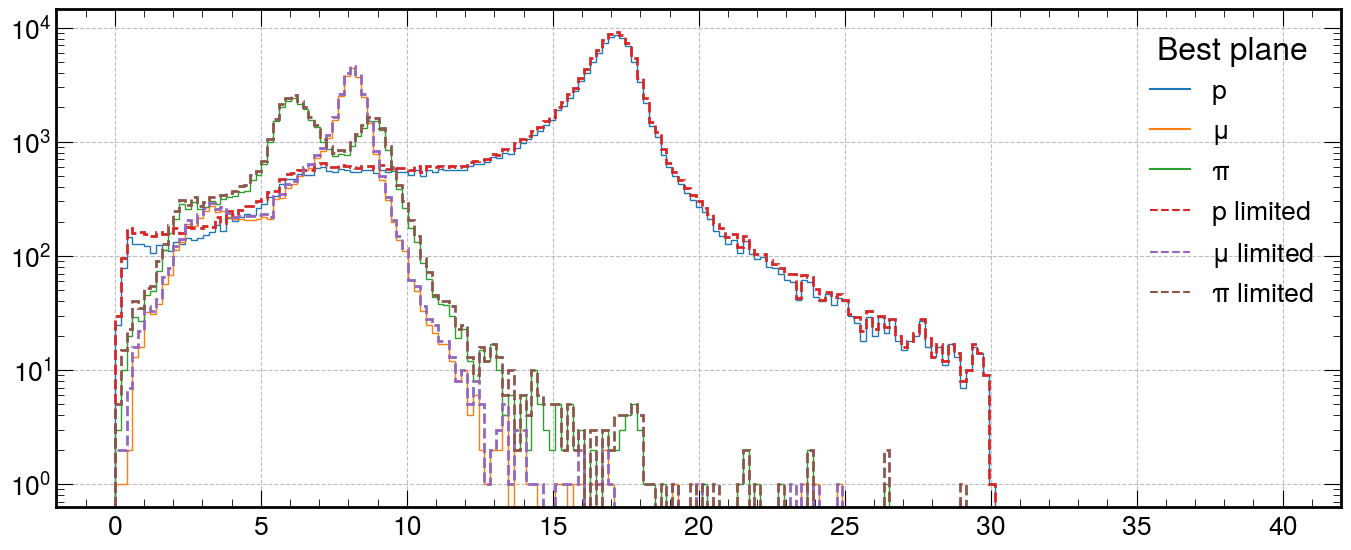

In [1568]:

from matplotlib.lines import Line2D

def plot_pid(df:pl.DataFrame,
            plane="B",
            pida = "trkpidpida",
            actual_variable = None,
            pdg=2212,
            binspid = np.linspace(0,40,200),
            notthispdg=False,
            threshold_pnc = 0.85,
            ShowersAndTracks=False,
            onlyShower=False,
            onlycontained=True,
            label="",
            onlyselected=True,
            **kwargs_hist,
            ):
    
    title = f'Plane {plane}'
    if plane=="B":
        # df = getbestof(df, 'trkg4pdg_planes')
        # df = getbestof(df, 'trkpidpida')
        # df = getbestof(df, 'trkpurity_planes')
        # df = getbestof(df, 'trkcompleteness_planes')
        title = 'Best plane'

    if onlyselected and 'selected' in df.columns:
        df = df.filter(
            pl.col('selected')
        )
    trkpdg = f"trkg4pdg_planes_{plane}"
    if (pdg != -1):
        if (notthispdg):
            df = df.filter(pl.col(trkpdg).abs()!=pdg)
        else:
            df = df.filter(pl.col(trkpdg).abs()==pdg)
        particlename = particle.Particle.from_pdgid(pdg).latex_name
        particlename = particlename.strip("^{+}")
        particlename = particlename.strip("^{-}")
    else:
        df = df.filter(
            pl.col(trkpdg).abs()!=2212,
            pl.col(trkpdg).abs()!=211,
            pl.col(trkpdg).abs()!=13,
        )
        particlename='others'
        
    df = df.filter(
        pl.col(f'trkpurity_planes_{plane}') > threshold_pnc,
        pl.col(f'trkcompleteness_planes_{plane}') > threshold_pnc,
        (ShowersAndTracks) | (pl.col('trkPFPIsTrack')),
        (not onlyShower) | ~(pl.col('trkPFPIsTrack')),
        ((not onlycontained) | pl.col(f'trkIsContained'))
    )
    if notthispdg:
        label = r'not ${{{}}}$'.format(particlename) + label
    else:
        label = r'${{{}}}$'.format(particlename) + label
        
    pida_p = f"{pida}_{plane}"
    if pida_p not in df.columns:
        pida_p = pida

    if actual_variable is not None:
        data = actual_variable(df)
    else:
        data = df[pida_p]
    plt.hist(data, binspid, histtype='step',label=label, **kwargs_hist)
    # Create new legend handles but use the colors from the existing ones
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor(), ls=h.get_linestyle()) for h in handles]
    
    plt.legend(title = title, handles=new_handles, labels=labels)
    return

plt.figure()
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=2212)
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=13)
plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=211)
# plot_pid(dftrkg4, 'B', ShowersAndTracks=False, pdg=-1)
plot_pid(dftrkg4_lim, 'B', ls='--', lw=2, label=' limited', ShowersAndTracks=True, pdg=2212)
plot_pid(dftrkg4_lim, 'B', ls='--', lw=2, label=' limited', ShowersAndTracks=True, pdg=13)
plot_pid(dftrkg4_lim, 'B', ls='--', lw=2, label=' limited', ShowersAndTracks=True, pdg=211)
# plot_pid(dftrkg4_lim, 'B', ls='--', lw=2, label='limited', ShowersAndTracks=False, pdg=-1)
plt.yscale('log')

81189 5256 0.06473783394302184
68424 6598 0.08794753538961904


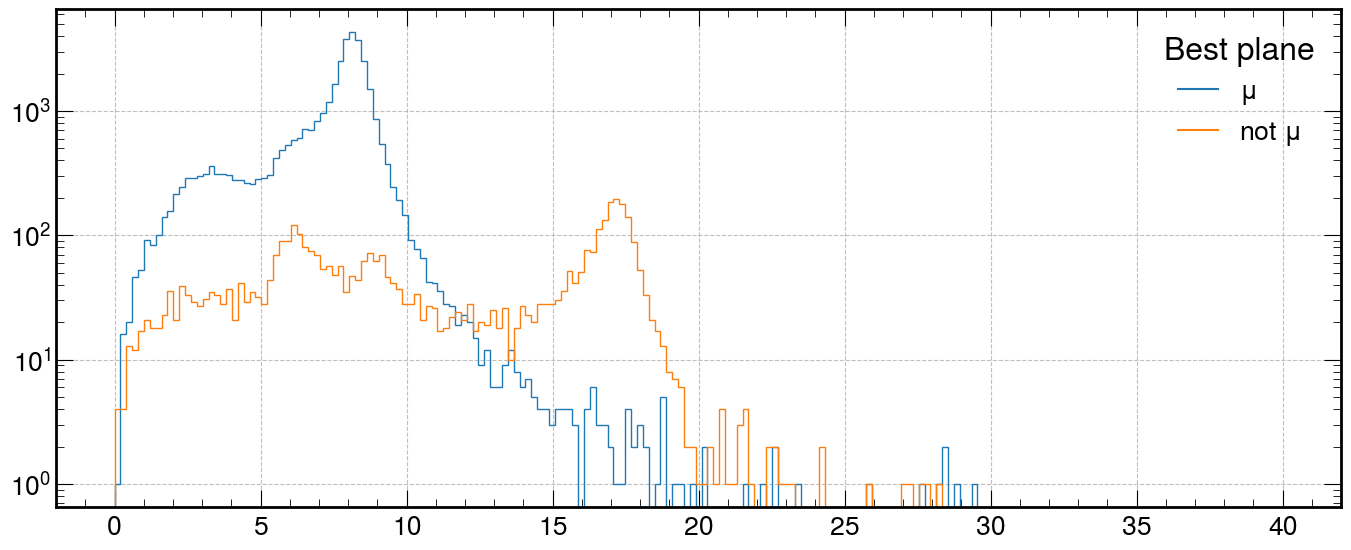

In [1569]:
def ismu():
    return pl.col('trkg4pdg_planes_B').abs()==13
dfall = dftrkg4.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 14
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity_planes_B')*pl.col('trkcompleteness_planes_B'),
)


minP = 0.5
minC = 0.5
dfall_enough_pnc = dfall.filter(
    pl.col('pnc') > minP*minC,
).group_by(selection_events()).agg(
    (pl.col('trkg4pdg_planes_B').abs() == 13).any().alias('hasmu')
)
print(len(dfall_enough_pnc), len(dfall_enough_pnc.filter(~pl.col('hasmu'))), len(dfall_enough_pnc.filter(~pl.col('hasmu')))/len(dfall_enough_pnc))

dfall_enough_pnc = dfall_enough_pnc.filter(
    pl.col('hasmu')
).select(selection_events())

dfall = dfall.join(dfall_enough_pnc, on=selection_events()).sort(selection_events())


dfmucandidate = dfall.sort('trklen').filter(
    pl.col('trklen') < 2e3,
    pl.col('trkPFPIsTrack')
).group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)
notmu = len(dfmucandidate.filter(
    pl.col('trkg4pdg_planes_B').abs() != 13
))
mu = len(dfmucandidate.filter(
    pl.col('trkg4pdg_planes_B').abs() == 13
))

dfallmu = dfall.group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)
print(mu, notmu, notmu/(mu+notmu))
plt.figure()
plot_pid(dfmucandidate, 'B', ShowersAndTracks=True, threshold_pnc=0, pdg=13)
plot_pid(dfmucandidate, 'B', ShowersAndTracks=True, threshold_pnc=0, pdg=13, notthispdg=True)

plt.yscale('log')

In [1570]:

def plot_purity_completeness(df:pl.DataFrame,
                             dffiltered:pl.DataFrame,
                             dfall:pl.DataFrame,
                             type="purity",
                             binse=None,
                             label=None,
                             ):
    
    if 'selected' in df.columns:
        df = df.filter(
            pl.col('selected')
        )
    if not binse:
        binse = np.logspace(-1,2, 100)
    bnall, b = np.histogram(dfall['enu_truth'], bins=binse)
    bn, b = np.histogram(df['enu_truth'], bins=binse)
    bnfiltered, b = np.histogram(dffiltered['enu_truth'], bins=binse)
    # plt.hist(b[:-1], b, weights=bn, histtype='step');

    completeness = np.divide(bn, bnall, out=np.zeros_like(bnall, dtype=np.float64), where=bnall!=0)
    purity = np.divide(bnfiltered, bn, out=np.zeros_like(bn, dtype=np.float64), where=bn!=0)
    if type=="completeness":
        val = completeness
    elif type=="purity":
        val = purity
    else:# type=="cnp":
        type = "P x C"
        val = purity*completeness

    plt.hist(b[:-1], b, weights=val, histtype='step', label=label);
    plt.ylabel(type.title())
    plt.xlabel('Neutrino energy [GeV]')
    plt.legend()
    return val, b

def print_ratio(a, b):
    try:
        print(a, b, np.divide(a,b, out=np.zeros_like(b, dtype=np.float64), where=b!=0))
    except Exception as error:
        # print(error)
        a=len(a.group_by(selection_events()).agg())
        b=len(b.group_by(selection_events()).agg())
        print(a, b, np.divide(a,b, out=np.zeros_like(b, dtype=np.float64), where=b!=0))
def plot_ratio(data, bins, var='enu_truth', general_filter=None, thefilter=None, plotnevents=False):
    if general_filter is not None:
        data = general_filter(data)
    if thefilter is None:
        def thefilter(df):
            return df.filter(ismu())
    data_filtered = thefilter(data)
    bt, b = np.histogram(data[var], bins=bins)
    bm, b = np.histogram(data_filtered[var], bins=bins)
    bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
    # print(sum(bm),sum(bt))
    plt.hist(b[:-1], b, weights=bratio, histtype='step')
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bt, alpha=0.2, log=False)
        # ax2.hist(b[:-1], b, weights=bm, alpha=0.2, log=False)
        ax2.set_ylabel(rf'n events')
        ax2.grid(False)
    plt.sca(ax)

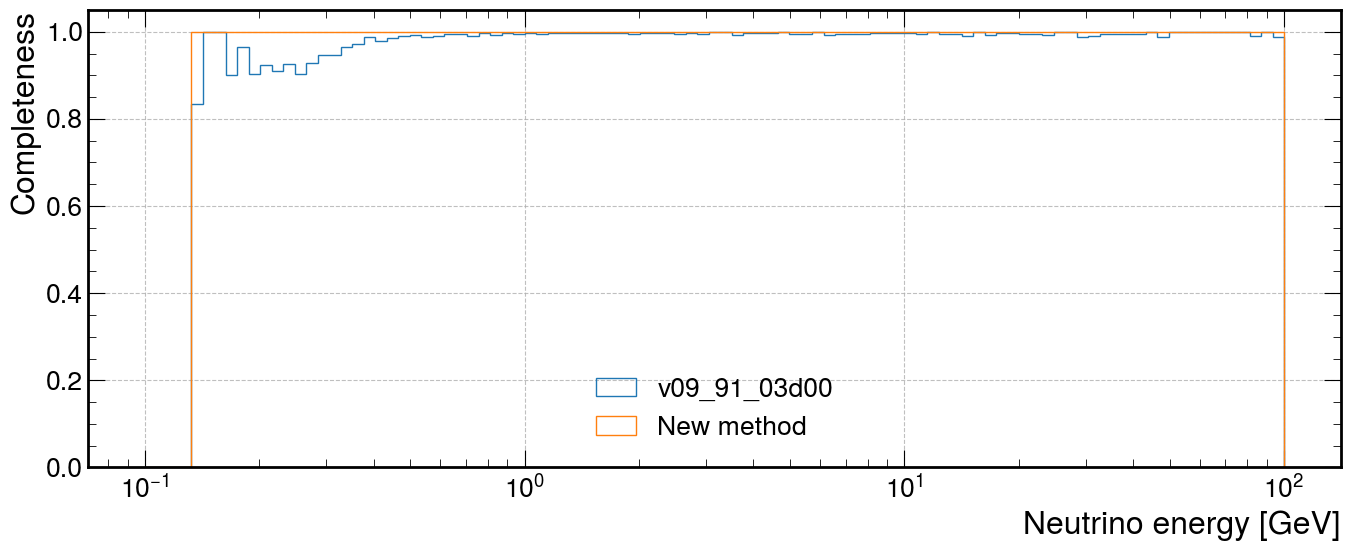

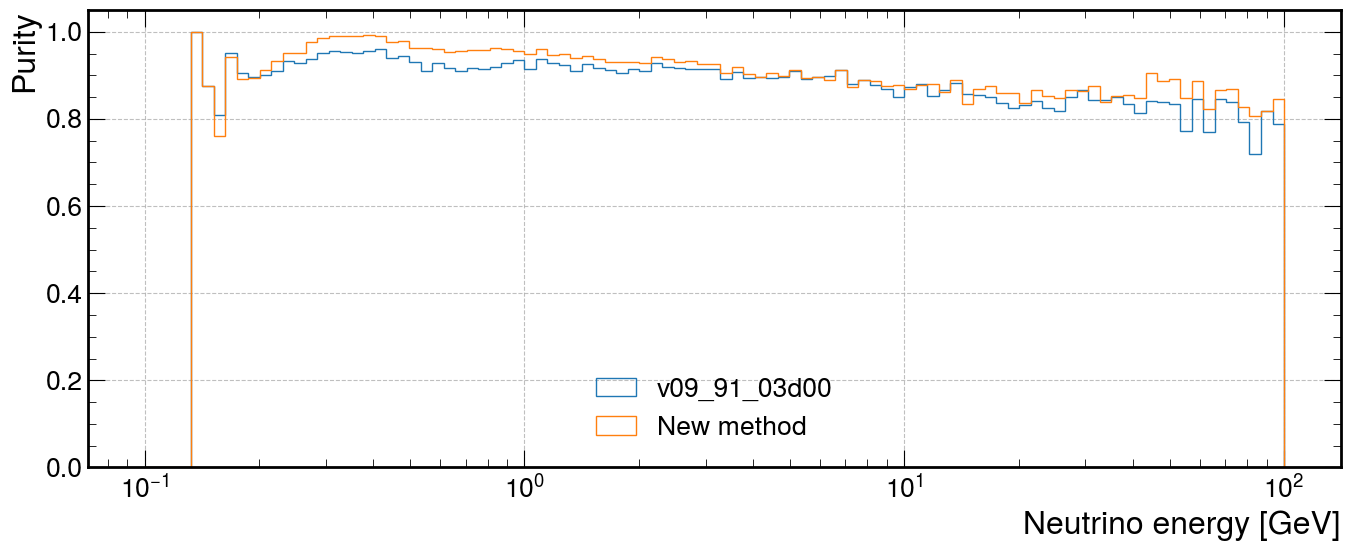

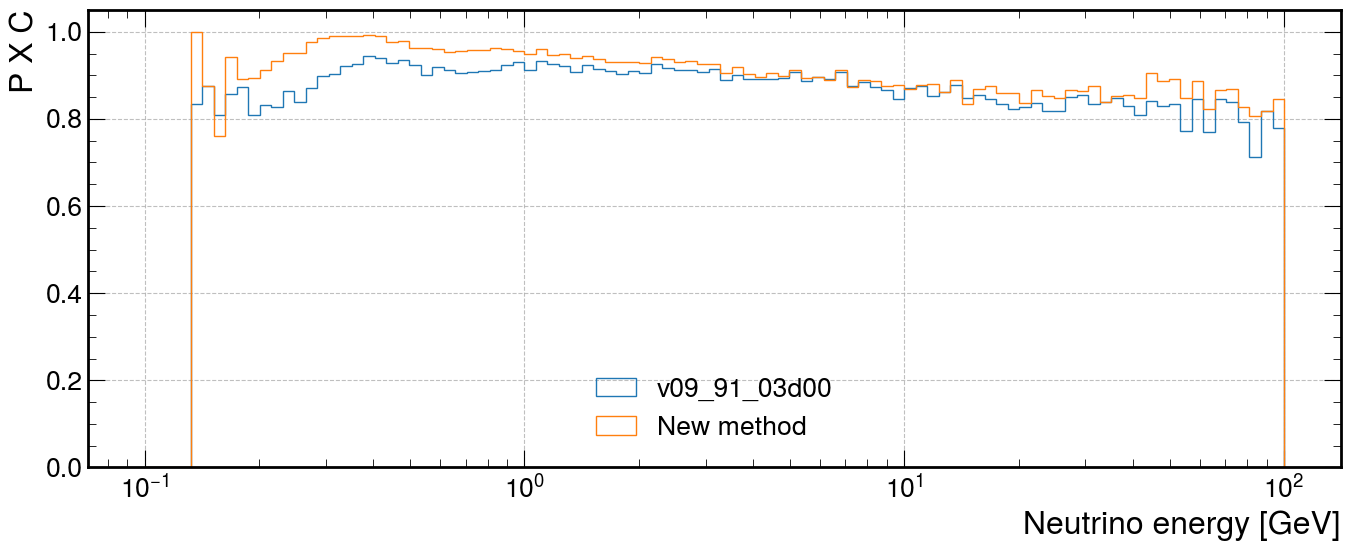

In [1571]:
from typing import List
# I tried 1e3 cut, virtually no change...
def create_mucandidates(df):
    dfselected = df.sort('trklen').filter(
        pl.col('trkPFPIsTrack')
    ).group_by(selection_events(), maintain_order=True).agg(
        pl.col('trkId').last(),
    ).with_columns(
        pl.lit(True).alias("selected")
    )
    df = df.join(dfselected, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
        pl.col('selected').fill_null(False)
    ).group_by(selection_events(), maintain_order=True).agg(
        pl.len().alias('noptions'),
        pl.all()
    ).explode(
        pl.all().exclude(selection_events('noptions'))
    )
    dfismu = df.filter(
        pl.col('selected'),
        pl.col('trkg4pdg_planes_B').abs() == 13
    )
    return df, dfismu

def get_dist_vtx(df:pl.DataFrame):
    return df.with_columns(
        (1/(
            (pl.col('trkstartx')- pl.col('recovtxx'))**2 + 
            (pl.col('trkstarty')- pl.col('recovtxy'))**2 + 
            (pl.col('trkstartz')- pl.col('recovtxz'))**2 
        ).sqrt()).alias('overdistvtx'),
    )
def get_options(df:pl.DataFrame):
    df = df.drop('noptions')
    df = df.group_by(selection_events(), maintain_order=True).agg(
        pl.len().alias('noptions'),
        pl.all()
    ).explode(
        pl.all().exclude(selection_events('noptions'))
    )
    return df
    
def get_biggest(df:pl.DataFrame,
                tailv:dict={'trklen':1,
                       'trkmomllhd':2,
                       'trkPFPScoreIsTrack':2,
                       'distvtx':2,
                      }
                ):
    listsort = [ k for k in  tailv.keys()]
    listvars = [ f'big_{k}' for k in  tailv.keys()]
    df = df.drop(listvars)
    for var, varsort, tt in zip(listvars, listsort, tailv.values()):
        if varsort not in df.columns:
            continue
        dfsel = df.sort(varsort,).group_by(selection_events(), maintain_order=True).agg(
            pl.col('trkId').tail(tt),
        ).explode(
            'trkId'
        ).with_columns(
            pl.lit(True).alias(var)
        )
        df = df.join(dfsel, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
            pl.col(var).fill_null(False)
        )
    return df
def get_rest(df:pl.DataFrame, restpidcut = 13):
    
    df = get_dist_vtx(df)
    df = get_options(df)
    df = df.filter(~((pl.col('trkpidpida_B')>=restpidcut) & (pl.col('noptions')>1)))
    df = get_options(df)
    firsttails = {
       'trklen': 1,
       'trkmomllhd': 1,
       'trkPFPScoreIsTrack': 1,
       'overdistvtx': 1,
    }
    df = get_biggest(df, firsttails)


    dffirst = df.with_columns(
        pl.when(((pl.col('big_trklen')) & (pl.col('big_trkPFPScoreIsTrack')) )).then(True).otherwise(False).alias('selected')
    ).filter(
        pl.col('selected')
    ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
        pl.col('trkId').last()
    )

    secondtails = {
       'trklen': 1,
       'trkmomllhd': 2,
       'trkPFPScoreIsTrack': 2,
       'overdistvtx': 2,
    }
    df = df.join(dffirst, on=selection_events(), how='anti')

    df = get_biggest(df, secondtails)
    df = get_options(df)

    dfsecond = df.with_columns(
        pl.when(((pl.col('big_trklen')) & pl.col('big_trkPFPScoreIsTrack')  )).then(True).otherwise(False).alias('selected')
    ).filter(
        pl.col('selected')
    ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
        pl.col('trkId').last()
    )

    dfselected = pl.concat([dffirst, dfsecond], how='vertical')
    
    return dfselected

def getfineselection(dforiginal:pl.DataFrame,
                     firstselect={"trklen":1,
                                  "trkmomllhd":3,
                                  "trkPFPScoreIsTrack":3},
                     ):

    df = dforiginal.filter(
        (pl.col('trklen')>10),
    )

    df = get_options(df)
    df = df.filter(
        ~((pl.col('trkmomllhd') > 4) & (pl.col('trklen')<50) & pl.col('noptions')>=2)
    )
    df = get_options(df)
    df = df.filter(
        (pl.col('trkmomllhd')> 2.1*1e-3*pl.col('trklen')+0.005) | (pl.col('noptions')==1),
    )
    df = get_biggest(df,firstselect)
    dfselected = df.with_columns(
        pl.when(((pl.col('big_trklen')) & (pl.col('big_trkmomllhd')) & (pl.col('trkmomllhd')>0) & (pl.col('big_trkPFPScoreIsTrack')))).then(True).otherwise(False).alias('selected')
    ).filter(
        pl.col('selected')
    ).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
        pl.all().last()
    )

    dfselected = dfselected.select(selection_events(['trkId']))
    
    return dfselected

def create_mucandidates_2(df:pl.DataFrame,
                          cut=1.7e3,
                          pidacut=13,
                          pidacut_low=10,
                          restpidcut=13,
                          filter_shower=True,
                          calocut=3,
                          calocutpida=0.1,
                          fineselection=True,
                          firstselect={"trklen":1,
                                      "trkmomllhd":3,
                                      "trkPFPScoreIsTrack":3},
                          afterfine = True,
                          includeall = True,
                          ):

    # if 'allcalo' not in df.columns:
    #     df = df.group_by(selection_events(), maintain_order=True).agg(
    #         pl.col('trkcalo_planes_B').sum().alias('allcalo'),
    #         pl.all()
    #     ).explode(pl.all().exclude(selection_events('allcalo')))


    calovariable = "allcalo_planes_B"
    dforiginal = df

    df = get_options(df)
    df = df.filter(
        ~((pl.col('trklen') >= cut) & (pl.col('noptions')>1)),
        # pl.col('trkPFPIsTrack'),
    )
    df = get_options(df)
    df = df.filter(
        ~((pl.col(calovariable) >= calocutpida) & (pl.col('trkpidpida_B') > pidacut) & (pl.col('noptions')>1)),
        # pl.col('trkPFPIsTrack'),
    )
    if filter_shower: 
    #     # Tested: there is only ~4% of tracks tagged as muon here with PxC > 0.36
        df = get_options(df)
        df = df.filter(
        ~((pl.col(calovariable).is_between(0.3,2)) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>1))
        )
        df = get_options(df)
        df = df.filter(
        ~((pl.col('trkpidpida_B') < 5) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>1))# & (pl.col("allcalo")>2))
        )

    df = get_options(df)
    dfallcontained = df.filter(
        (pl.col(calovariable) >= calocut) & ~(pl.col('trkIsContained')) & (pl.col('noptions')>1)
    ).group_by(selection_events()).agg(
    ).with_columns(
        pl.lit(True).alias('allcontained')
    )
    df = df.join(dfallcontained, on=selection_events(), how='left', coalesce=True).with_columns(
        pl.col('allcontained').fill_null(False)
    )
    df = df.filter(
        ~((pl.col(calovariable) >= calocut) & (pl.col('trkIsContained')) & (pl.col('allcontained'))),
    )
    df = get_options(df)
    df = df.filter(
        ~((pl.col(calovariable) >= calocut) & ~(pl.col('trkPFPIsTrack')) & (pl.col('noptions')>=2)),
        ~((pl.col(calovariable) >= calocut) & ~(pl.col('trkPFPIsTrack')) & (pl.col('trkpidpida_B')>=pidacut_low)),
    )
    df = df.filter(
        ~((pl.col(calovariable) >= calocut) & (pl.col('trkPFPIsTrack')) & (pl.col('noptions')>=2) & (pl.col('trkpidpida_B')>pidacut_low)),
    )
    df = df.with_columns(
        pl.lit(True).alias('candidate')
    )
    df = get_options(df)
    if fineselection:
        dfselected = getfineselection(df, firstselect=firstselect) 
    else:
        dfselected = df.sort(
            'trklen',
        ).group_by(selection_events(), maintain_order=True).agg(
            pl.col('trkId').last(),
        )

    if afterfine:
        dfrest = dforiginal.join(dfselected, on=selection_events(), how='anti')
        dfrestselected = get_rest(dfrest, restpidcut=13)
        dfrestselected = dfrestselected
        dfselected = pl.concat([dfselected, dfrestselected], how='vertical')

    dfrest = dforiginal.join(dfselected, on=selection_events(), how='anti')
    if includeall:
        dfrestselected = dfrest.sort('trklen').group_by(selection_events()).agg(
            pl.col('trkId').last()
        )
        dfselected = pl.concat([dfselected, dfrestselected], how='vertical')


    dfselected = dfselected.with_columns(
        pl.lit(True).alias("candidate"),
        pl.lit(True).alias("selected"),
    )
    # dforiginal = df
    dforiginal = dforiginal.join(dfselected, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
        pl.col('candidate').fill_null(False),
        pl.col('selected').fill_null(False),
    )
    dfismu = dforiginal.filter(
        pl.col('selected'),
        pl.col('trkg4pdg_planes_B').abs() == 13
    )
    return dforiginal, dfismu
# plt.hist(b[:-1], b, weights=completeness, histtype='step');
dfmuca = []
dfmucamu = []
i =0;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates(dfall)
# # i+=1;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates_2(dfall, fineselection=False, includeall=False, afterfine=False)
# # i+=1;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates_2(dfall, fineselection=False, includeall=False, afterfine=True)
i+=1;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates_2(dfall, fineselection=False, includeall=True, afterfine=True)
# # i+=1;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates_2(dfall, fineselection=True, includeall=False, afterfine=False)
# i+=1;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates_2(dfall, fineselection=True, includeall=False, afterfine=True)
# # i+=1;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates_2(dfall, fineselection=True, includeall=True, afterfine=False)
# # i+=1;dfmuca.append(0); dfmucamu.append(0); dfmuca[i], dfmucamu[i] = create_mucandidates_2(dfall, fineselection=True, includeall=True, afterfine=False)

labels = [ i for i in range(len(dfmuca))]
if len(labels)==2:
    labels = ['v09_91_03d00', 'New method']

plt.figure()
for i, (dfc, dfcmu, label) in enumerate(zip(dfmuca, dfmucamu, labels)):
    plot_purity_completeness(dfc, dfcmu, dfallmu, type='completeness', label=label)
    plt.xscale('log')
    plt.savefig('c.png', dpi=200)
plt.figure()
for i, (dfc, dfcmu, label) in enumerate(zip(dfmuca, dfmucamu, labels)):
    plot_purity_completeness(dfc, dfcmu, dfallmu, type='purity', label=label)
    plt.xscale('log')
    plt.savefig('p.png', dpi=200)
plt.figure()

pncs = []*len(dfmuca)
pncsbins = 0
for i, (dfc, dfcmu, label) in enumerate(zip(dfmuca, dfmucamu, labels)):
    v, b = plot_purity_completeness(dfc, dfcmu, dfallmu, type='pnc', label=label)
    pncs.append(v)
    pncsbins=b
    plt.xscale('log')
    plt.savefig('pnc.png', dpi=200)


# plt.figure()
# dfcheck = dfmucandidate2.filter(pl.col('enu_truth')>0)
# print_ratio(len(dfcheck.filter(pl.col('trkpidpida_B')>=15, ismu())),len(dfcheck))
# print_ratio(len(dfcheck.filter(pl.col('trkpidpida_B')>=15, ~ismu())),len(dfcheck))
# plot_pid(dfcheck, 'B',threshold_pnc=0,  onlyShower=False, ShowersAndTracks=True, pdg=13)
# plot_pid(dfcheck, 'B',threshold_pnc=0,  onlyShower=False, ShowersAndTracks=True, pdg=13, notthispdg=True)
# plt.yscale('log')

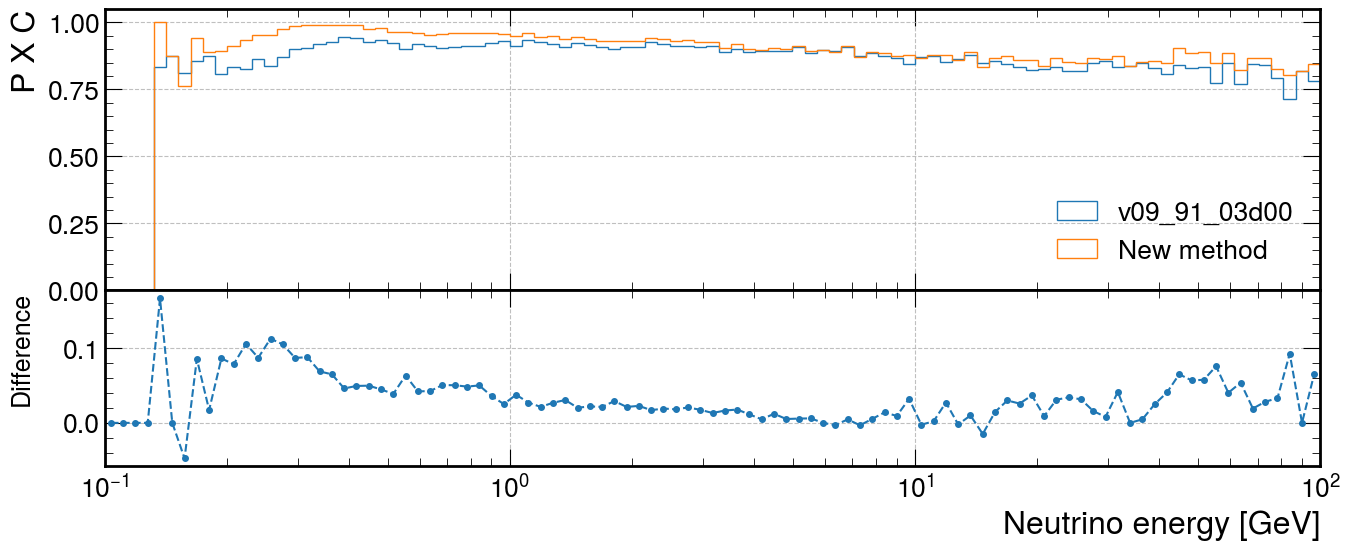

In [1572]:

if len(labels)==2:
    fig = plt.figure()
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1.6, 1], hspace=0)
    axs = gs.subplots(sharex=True)
    pncs = []*len(dfmuca)
    pncsbins = 0
    plt.sca(axs[0])
    for i, (dfc, dfcmu, label) in enumerate(zip(dfmuca, dfmucamu, labels)):
        v, b = plot_purity_completeness(dfc, dfcmu, dfallmu, type='pnc', label=label)
        pncs.append(v)
        pncsbins=b
    bins_center = (b[:-1] + b[1:])*0.5
    axs[1].plot(bins_center, pncs[1]-pncs[0], '.--', ms=8)
    axs[1].set_xlabel('Neutrino energy [GeV]')
    axs[1].set_ylabel('Difference', labelpad=20, fontsize=18)
    # axs[1].set_ylim(-0.05,0.17)
    # plt.hist(pncsbins[:-1], pncsbins, weights=pncs[1]- pncs[0], histtype='step')
    plt.xscale('log')
    plt.xlim(1e-1,1e2)

shape: (283_376, 122)
┌─────────┬────────┬───────┬─────────────┬───┬───────────────────┬──────────┬───────────┬──────────┐
│ run     ┆ subrun ┆ event ┆ nuPDG_truth ┆ … ┆ nallhits_planes_B ┆ pnc      ┆ candidate ┆ selected │
│ ---     ┆ ---    ┆ ---   ┆ ---         ┆   ┆ ---               ┆ ---      ┆ ---       ┆ ---      │
│ i32     ┆ i32    ┆ i32   ┆ i32         ┆   ┆ i32               ┆ f32      ┆ bool      ┆ bool     │
╞═════════╪════════╪═══════╪═════════════╪═══╪═══════════════════╪══════════╪═══════════╪══════════╡
│ 1453    ┆ 1      ┆ 7     ┆ 14          ┆ … ┆ 55                ┆ 0.142857 ┆ false     ┆ false    │
│ 1453    ┆ 1      ┆ 7     ┆ 14          ┆ … ┆ 55                ┆ 0.909091 ┆ false     ┆ false    │
│ 1453    ┆ 1      ┆ 7     ┆ 14          ┆ … ┆ 122               ┆ 0.982609 ┆ true      ┆ true     │
│ 1453    ┆ 1      ┆ 8     ┆ 14          ┆ … ┆ 73                ┆ 0.894737 ┆ true      ┆ true     │
│ 1453    ┆ 1      ┆ 10    ┆ 14          ┆ … ┆ 2174              ┆ 0.

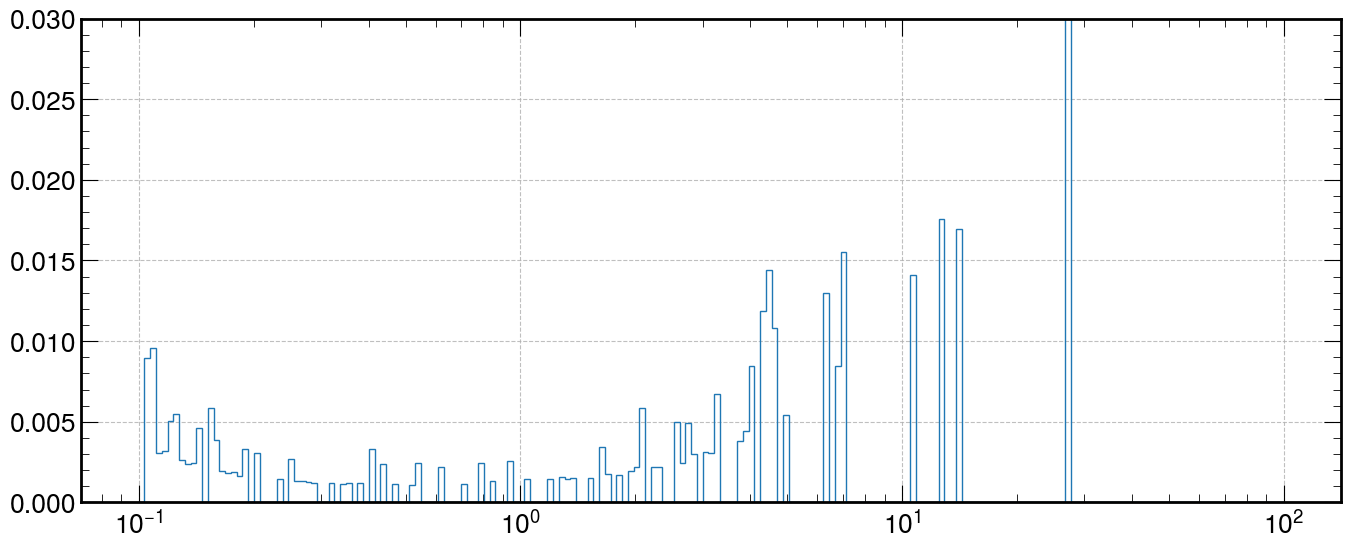

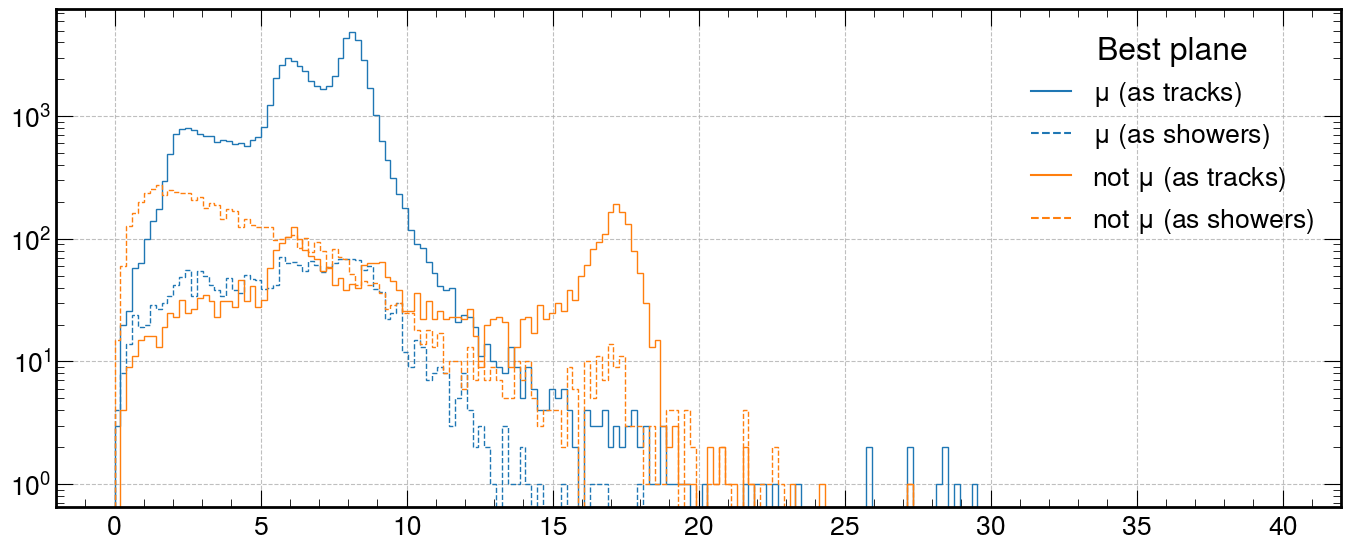

In [1575]:
# VERY GOOD! Showed me that the cut pida < 15 needs to be applied above 500 MeV *200 MeV all calo
dfcheck, _ = create_mucandidates_2(df=dfall, calocutpida=1e12, filter_shower=False, calocut=1e12, fineselection=False, includeall=False, afterfine=False)

print(dfcheck)
dfcheck = dfcheck.filter(pl.col('selected'))

plt.figure()
threshold=13
binse = np.logspace(-1,2,200)
bt, b = np.histogram(dfcheck.filter(True)['allcalo_planes_B'], bins=binse)
bm, b = np.histogram(dfcheck.filter(pl.col('trkpidpida_B')>threshold, ismu())['allcalo_planes_B'], bins=binse)
bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
plt.hist(b[:-1], b, weights=bratio, histtype='step')
plt.ylim(0,0.03)
plt.xscale('log')

plt.figure()
# dfcheck = dfcheck.filter(pl.col('allcalo_planes_B')<0.1)
print_ratio(len(dfcheck.filter(pl.col('trkpidpida_B')>=threshold, ismu())),len(dfcheck))
print_ratio(len(dfcheck.filter(pl.col('trkpidpida_B')>=threshold, ~ismu())),len(dfcheck))
plot_pid(dfcheck, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, label=' (as tracks)', ShowersAndTracks=False)
plot_pid(dfcheck, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, label=' (as showers)', ls='--', color="C0", ShowersAndTracks=True, onlyShower=True)
plot_pid(dfcheck, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, notthispdg=True, label=' (as tracks)', ShowersAndTracks=False)
plot_pid(dfcheck, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, notthispdg=True, label=' (as showers)', ls='--', color="C1", ShowersAndTracks=True, onlyShower=True)
plt.yscale('log')

(0.0, 0.12)

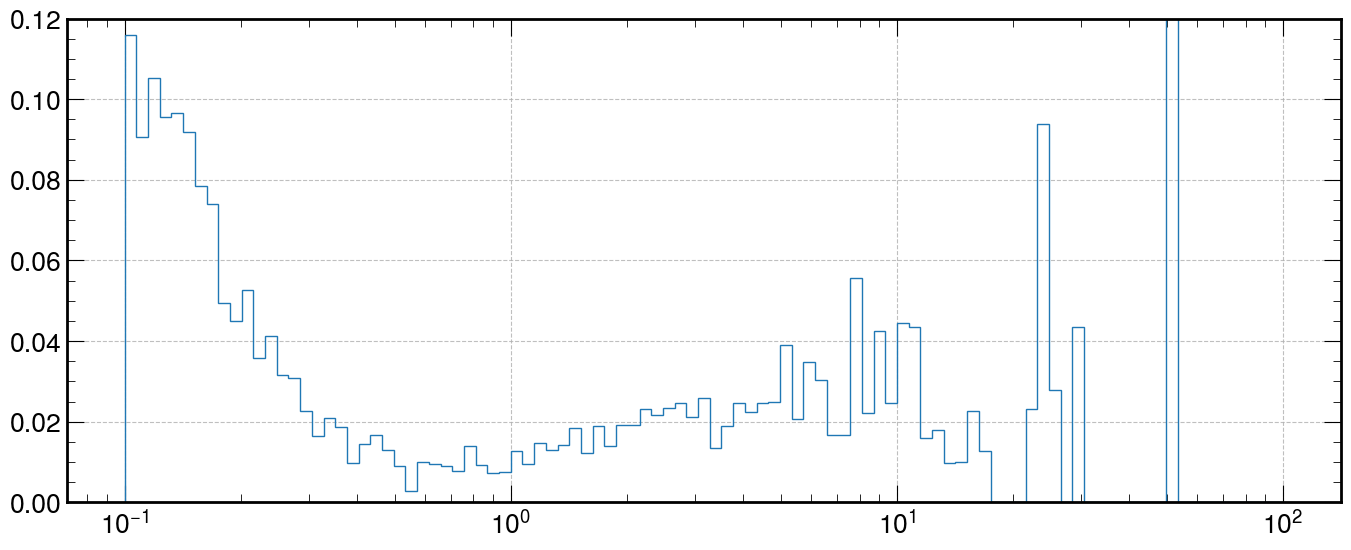

In [1576]:
# Lets see
dfcheck, _ = create_mucandidates_2(df=dfall, filter_shower=False, calocut=1e6)
dfcheck = dfcheck.filter(pl.col('selected'))

plt.figure()
binse = np.logspace(-1,2,100)
var='allcalo_planes_B'
bt, b = np.histogram(dfcheck.filter(True)[var], bins=binse)
bm, b = np.histogram(dfcheck.filter(~pl.col('trkPFPIsTrack'), ismu())[var], bins=binse)
bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
plt.hist(b[:-1], b, weights=bratio, histtype='step')
plt.xscale('log')
plt.ylim(0,0.12)


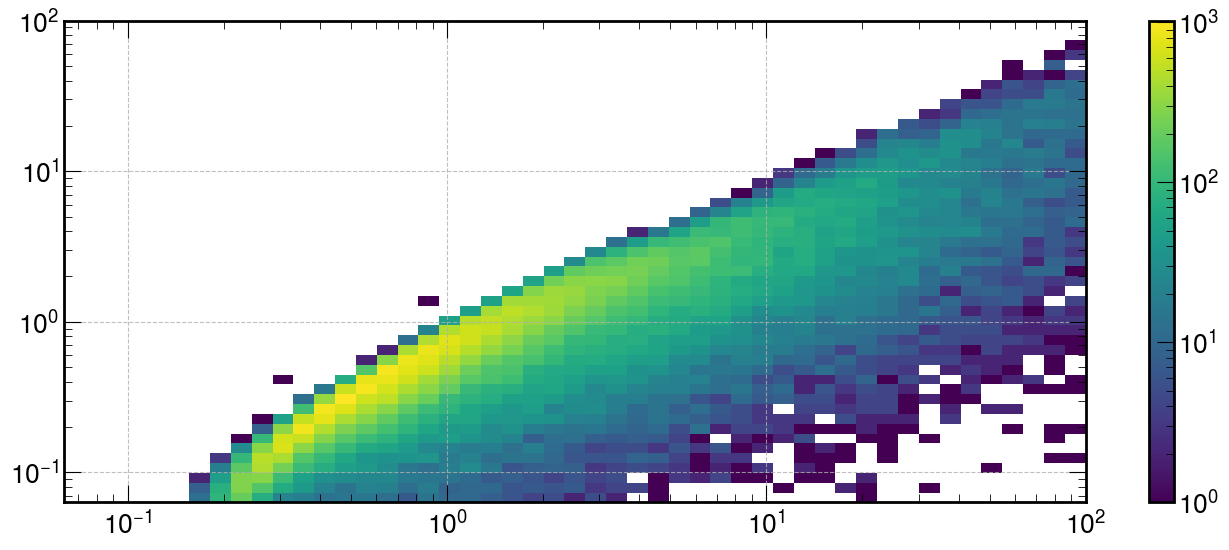

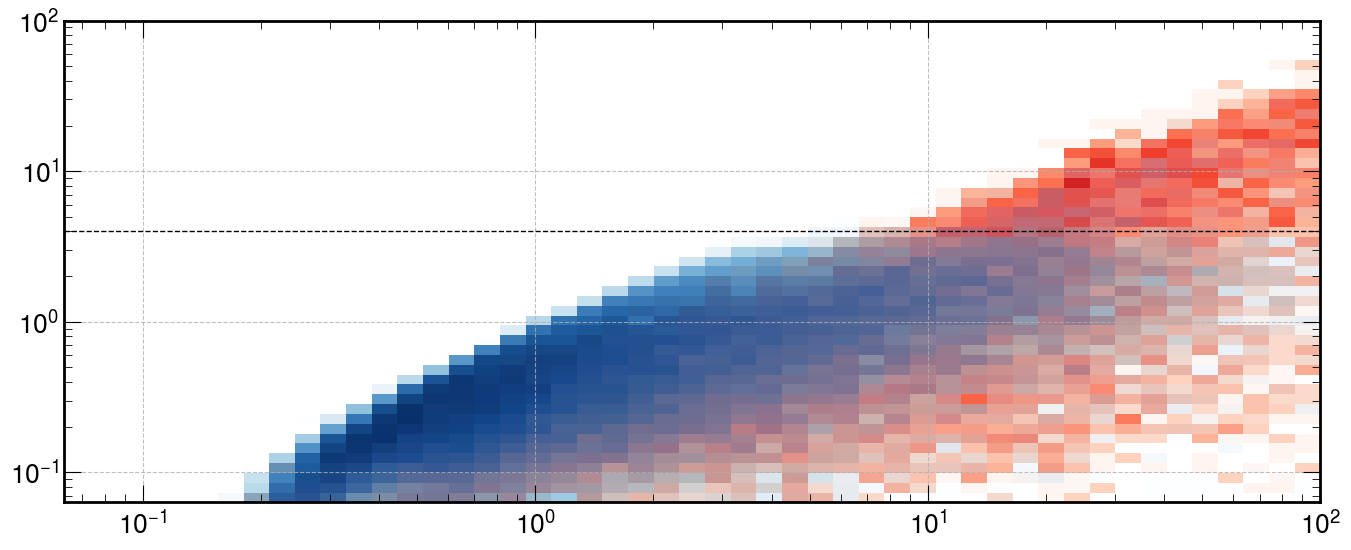

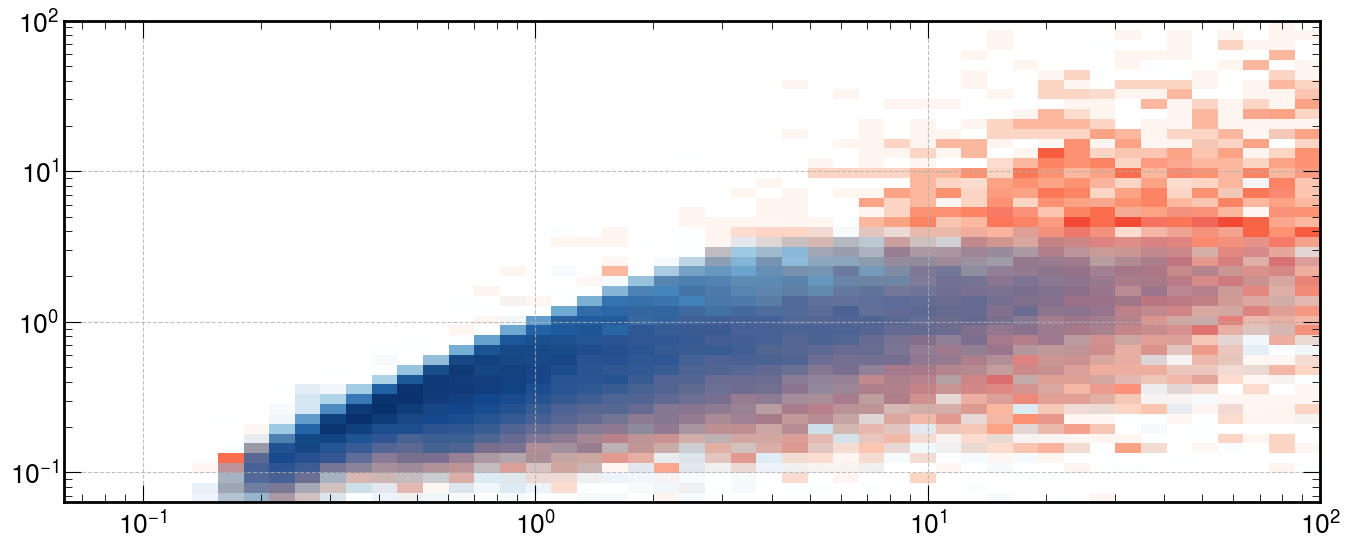

In [1577]:
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pylab

# modify existing Reds colormap with a linearly fading alpha
red = pylab.cm.Blues  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red[:, -1] = np.linspace(0.2, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

dfcalo = dfall.sort('trklen').group_by(selection_events()).agg(
    pl.col('trkcalo_planes_B').sum().alias('allcalo'),
    pl.all().last(),
)
dfcaloismu = dfcalo.filter(
    pl.col('trkg4pdg_planes_B').abs()==13
)
dfcaloisnotmu = dfcalo.filter(
    pl.col('trkg4pdg_planes_B').abs()!=13,
    # pl.col('trkmomrange_mu') < 4,
    # pl.col('trkcalo_planes_B') < 4,
)
binse=np.logspace(-1.2,2,50)
plt.hist2d(dfcalo['enu_truth'], dfcalo['allcalo_planes_B'], bins=binse, norm='log');
plt.colorbar()
plt.yscale('log')
plt.xscale('log')
plt.figure()
plt.hist2d(dfcaloisnotmu['enu_truth'], dfcaloisnotmu['trkcalo_planes_B'], bins=binse, norm='log', cmap="Reds");
plt.hist2d(dfcaloismu['enu_truth'], dfcaloismu['trkcalo_planes_B'], bins=binse, norm='log', cmap=fading_red);
plt.axhline(4, ls="--", color='k', lw=1)
plt.yscale('log')
plt.xscale('log')
plt.figure()
plt.hist2d(dfcaloisnotmu['enu_truth'], dfcaloisnotmu['trkmomrange_mu'], bins=binse, norm='log', cmap="Reds");
plt.hist2d(dfcaloismu['enu_truth'], dfcaloismu['trkmomrange_mu'], bins=binse, norm='log', cmap=fading_red);
plt.yscale('log')
plt.xscale('log')

How many are selected as muons
6703 7422 0.9031258420910806
Out of everything, I lose around x% because there is no actual muon
6703 7422 0.9031258420910806
6703 719


run,subrun,event,noptions,nhits,density,trkId,trkstartx,trkstarty,trkstartz,trkendx,trkendy,trkendz,trkpurity,trkcompleteness,trkg4id,trkg4pdg,trkg4en,trkg4mass,trkg4origin,trknhits,trkbestplane,trklen,trkmomllhd,trkIsContained,trkPFPIsTrack,trkPFPScoreIsTrack,trkIsContained2,trkg4id_planes_B,trkg4pdg_planes_B,trkg4en_planes_B,trkg4mass_planes_B,trkg4origin_planes_B,trkpurity_planes_B,trkcompleteness_planes_B,trknhits_planes_B,trknhitsmatch_planes_B,trkcalo_planes_B,trktotalen_planes_B,trkpartialen_planes_B,trkpidndf_B,trkpidchi2pr_B,trkpidchi2ka_B,trkpidchi2pi_B,trkpidchi2mu_B,trkpidpida_B,allcalo_planes_B,nallhits_planes_B
i32,i32,i32,list[u32],list[i32],list[f64],list[i16],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[i32],list[i32],list[f32],list[f32],list[i32],list[i32],list[i32],list[f32],list[f32],list[bool],list[bool],list[f32],list[bool],list[i32],list[i32],list[f32],list[f32],list[i32],list[f32],list[f32],list[i32],list[i32],list[f32],list[f32],list[f32],list[i32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[i32]


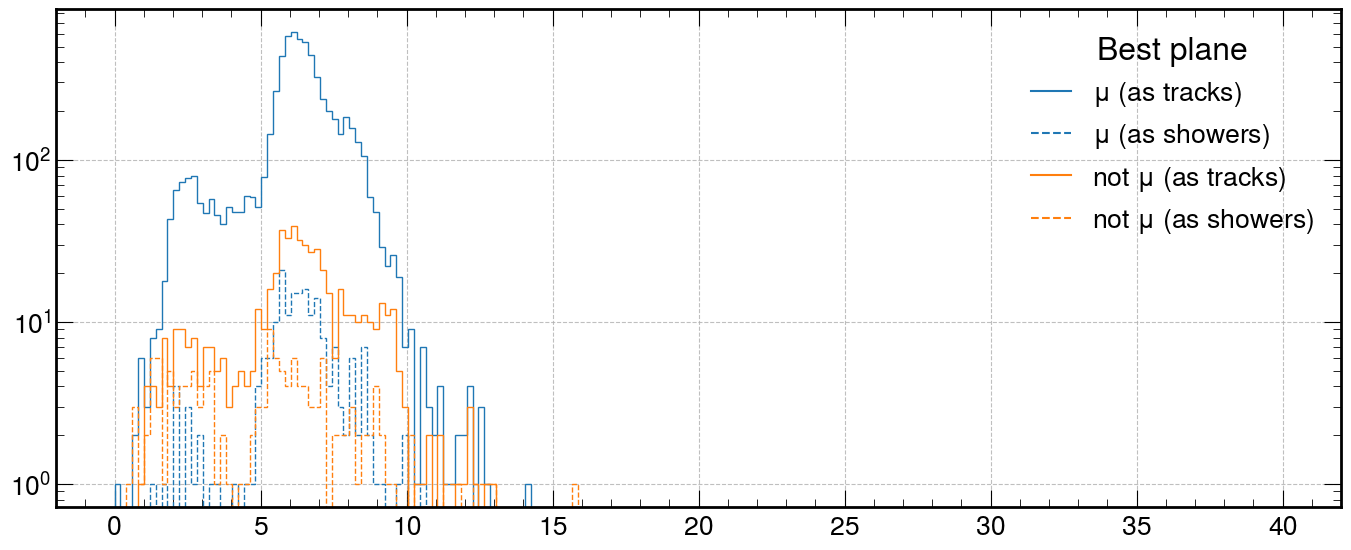

<Figure size 1400x600 with 0 Axes>

In [1581]:

plt.figure()
dftest, dftestismu = create_mucandidates_2(dfall, pidacut=13, calocutpida=0.1, filter_shower=True)#, calocut=3)
dftest = dftest.filter(pl.col('allcalo_planes_B')>3)
dftest = get_options(dftest)
dftest = dftest.filter(
    True,
    pl.col('selected'),
    pl.col('noptions')>=2,
    # pl.col('trkPFPIsTrack'),
)
plot_pid(dftest, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, label=' (as tracks)', ShowersAndTracks=False)
plot_pid(dftest, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, label=' (as showers)', ls='--', color="C0", ShowersAndTracks=True, onlyShower=True)
plot_pid(dftest, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, notthispdg=True, label=' (as tracks)', ShowersAndTracks=False)
plot_pid(dftest, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, notthispdg=True, label=' (as showers)', ls='--', color="C1", ShowersAndTracks=True, onlyShower=True)
totalismu = len(dftest.filter(pl.col('selected'),ismu()))
dftotal = dftest.group_by(selection_events(), maintain_order=True).agg(pl.col('enu_truth').first())
total = len(dftotal)
print("How many are selected as muons")
print(totalismu, total, totalismu/(total))
totalismu = len(dftest.group_by(selection_events()).agg((pl.col('trkg4pdg_planes_B').abs()==13).any().alias('mu')).filter(pl.col('mu')))
dftotal = dftest.group_by(selection_events(), maintain_order=True).agg(pl.col('enu_truth').first())
total = len(dftotal)
print("Out of everything, I lose around x% because there is no actual muon")
print(totalismu, total, totalismu/(total))
plt.yscale('log')

plt.figure()
dftest = dftest.with_columns(
    nhits=
    pl.col("trknhits_planes_U")+
    pl.col("trknhits_planes_V")+
    pl.col("trknhits_planes_W")
).with_columns(
    density=pl.col('trklen')/pl.col('nhits')
)
dftestmu = dftest.filter(
    # pl.col('selected'),
    # pl.col('trklen')>=10,
    ismu(),
)
dftestnotmu = dftest.filter(
    # ~pl.col('selected'),
    # pl.col('trklen')>=10,
    ~ismu()
)
print(len(dftestmu), len(dftestnotmu))
# binsx = np.logspace(-2,3,200)
# binsy = np.logspace(-1,1.5,200)
# x='trklen'
# y='trknhits_planes_B'
# plt.scatter(dftestmu[x], dftestmu[y],)
# plt.scatter(dftestnotmu[x], dftestnotmu[y], s=90, edgecolors='C1', facecolor='none', alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
dfgood = dftest.filter(pl.col('selected'), ismu()).group_by(selection_events()).agg()
dfnotgood = dftest.join(dfgood, on=selection_events(), how='anti')
dfnomuatall = dfnotgood.group_by(selection_events(), maintain_order=True).agg(
    (pl.col('trkg4pdg_planes_B').abs()==13).any().alias('mu')
).filter(~pl.col('mu'))
dfnotgood = dfnotgood.join(dfnomuatall, on=selection_events(), how='anti')
dfnotgood.sort((13-pl.col('trkg4pdg_planes_B').abs()).abs()).group_by(selection_events(), maintain_order=True).agg(
    pl.all()
).select(
    pl.col('run'), pl.col('subrun'), pl.col('event'), pl.col('noptions'),
    pl.col('nhits'), pl.col('density'),
    pl.col('^trk[^_]*$'),
    pl.col('^.*_B$')
)

In [200]:
dftest, _ = create_mucandidates_2(dfall)#, calocut=3.5, pidacut=15)

dft = dftest.filter(
    ismu(),
).sort('pnc').group_by(selection_events(), maintain_order=True).agg(
    pl.len(),
    pl.all().last()
# ).filter( #used for testing filter of showers
#     pl.col('pnc') > 0.6*0.6
)
totalismu = len(dft.filter(ismu()))
dftotal = dftest.group_by(selection_events(), maintain_order=True).agg(pl.col('enu_truth').first())
total = len(dftotal)
print("Out of everything, I lose around x% because there is no actual muon")
print(totalismu, total, totalismu/(total))
# bt, b = np.histogram(dftotal['enu_truth'],bins=binse)
# bismu, b = np.histogram(dft['enu_truth'],bins=binse)
# bratio = np.divide(bismu, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
# plt.hist(b[:-1], b, weights=bratio, histtype='step')
# plt.xscale('log')

dft = dftest.group_by(selection_events(), maintain_order=True).agg(
    pl.len(),
    pl.all().first()
)
dft = dft.filter(
    pl.col('len')==1
)

totalismu = len(dft.filter(ismu()))
total= len(dft)
print("\nHere are the lonely that are the muon")
print(totalismu, total, totalismu/(total))


dft2 = dftest.group_by(selection_events(), maintain_order=True).agg(
    pl.len(),
    pl.all(),
).explode(
    pl.all().exclude(selection_events('len'))
).filter(
    pl.col('len')>2
)

dft = dft2.sort(
    pl.col('trklen')
# ).filter(
#     pl.col('trkPFPIsTrack')
).group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
).filter(
    ~ismu()
)

totalismu = len(dft)
total= len(dft2.group_by(selection_events()).agg())
print("\nHere are the multiples that are the muon")
print(totalismu, total, totalismu/(total))
# plt.hist2d(dft['enu_truth'], dft['trkcalo_planes_B'], bins=[binse, np.logspace(-2, 2, 200)], norm='log');
# plt.xscale('log')
# plt.yscale('log')

dfnotamu = dft2.join(dft.select(selection_events()), on=selection_events())
dfnotamu.select(selection_events(['trklen','trkg4pdg_planes_B']))
# dfall.filter(
#     True,
#     filter_event(6420853, 1, 89323)
# )

Out of everything, I lose around x% because there is no actual muon
73325 74462 0.9847304665466949

Here are the lonely that are the muon
38407 39109 0.982050167480631

Here are the multiples that are the muon
2116 13574 0.1558862531309857


run,subrun,event,trklen,trkg4pdg_planes_B
i32,i32,i32,f32,i32
1497,1,15711,65.680336,-211
1497,1,15711,169.513428,22
1497,1,15711,9.942839,22
1497,1,15711,147.740997,-13
1497,1,15734,203.692505,211
…,…,…,…,…
6435715,1,67157,60.817032,-211
6435715,1,67157,7.848263,211
6435715,1,67190,48.422184,13


Max purity
13953 14164 0.9851030782264897
This many muons if take longest
11908 14081 0.8456785739649173
First selection
6001 6436 0.9324114356743319
second round max purity
7300 7558 0.9658639851812649
Second selection
4732 5757 0.8219558797985062
Final... 
10733 12193 0.8802591650947265


run,subrun,event,noptions,biglen,bigllhd,bigscore,trkId,trkstartx,trkstarty,trkstartz,trkendx,trkendy,trkendz,trkpurity,trkcompleteness,trkg4id,trkg4pdg,trkg4en,trkg4mass,trkg4origin,trknhits,trkbestplane,trklen,trkmomllhd,trkIsContained,trkPFPIsTrack,trkPFPScoreIsTrack,trkIsContained2,trkg4id_planes_B,trkg4pdg_planes_B,trkg4en_planes_B,trkg4mass_planes_B,trkg4origin_planes_B,trkpurity_planes_B,trkcompleteness_planes_B,trknhits_planes_B,trknhitsmatch_planes_B,trkcalo_planes_B,trktotalen_planes_B,trkpartialen_planes_B,trkpidndf_B,trkpidchi2pr_B,trkpidchi2ka_B,trkpidchi2pi_B,trkpidchi2mu_B,trkpidpida_B,allcalo_planes_B,nallhits_planes_B
i32,i32,i32,list[u32],list[bool],list[bool],list[bool],list[i16],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[i32],list[i32],list[f32],list[f32],list[i32],list[i32],list[i32],list[f32],list[f32],list[bool],list[bool],list[f32],list[bool],list[i32],list[i32],list[f32],list[f32],list[i32],list[f32],list[f32],list[i32],list[i32],list[f32],list[f32],list[f32],list[i32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[i32]
1453,1,87,[2],[true],[true],[true],[0],[-3.924634],[517.256348],[1333.034546],[-24.987635],[491.985291],[1392.047852],[0.944737],[0.871359],[1],[13],[1.011186],[0.105658],[1],[380],[1],[67.584137],[0.43087],[false],[true],[0.761667],[false],[1],[13],[1.011186],[0.105658],[1],[0.985507],[0.860759],[138],[136],[0.155384],[145.987473],[16.965517],[59],[202.0448],[95.390038],[18.896791],[11.977061],[5.840853],[0.632122],[314]
1497,1,447,[6],[true],[true],[true],[0],[-158.388977],[216.243546],[135.153458],[-212.19751],[145.551041],[0.422777],[0.967337],[0.990991],[1],[13],[2.364156],[0.105658],[1],[796],[0],[161.394653],[1.713081],[false],[true],[0.785921],[false],[1],[13],[2.364156],[0.105658],[1],[0.964809],[0.990964],[341],[329],[0.471911],[395.285675],[19.523718],[60],[228.163498],[92.290649],[13.063057],[8.550922],[5.514526],[1.849463],[1182]
1497,1,468,[2],[true],[true],[true],[0],[138.110336],[488.034607],[1063.589966],[137.032928],[588.635071],[1038.126953],[0.954984],[1.0],[1],[13],[0.37686],[0.105658],[1],[311],[0],[103.860817],[0.567184],[false],[true],[0.750479],[true],[1],[13],[0.37686],[0.105658],[1],[0.96],[1.0],[175],[168],[0.299347],[257.238007],[44.089268],[48],[103.253853],[32.239155],[1.99772],[2.082676],[8.574151],[0.858471],[352]
1497,1,477,[2],[true],[true],[true],[0],[-37.126148],[-268.558258],[180.22789],[208.103714],[-599.631348],[557.951721],[0.989145],[0.840901],[1],[-13],[3.115461],[0.105658],[1],[2303],[0],[559.583374],[1.8961],[false],[true],[0.790858],[false],[1],[-13],[3.115461],[0.105658],[1],[0.989173],[0.854592],[1016],[1005],[1.406972],[1288.483276],[26.280405],[58],[185.497131],[67.106728],[14.354336],[9.21999],[6.87642],[1.761628],[1271]
1497,1,490,[2],[true],[true],[true],[0],[67.481224],[-410.915894],[508.661957],[-362.625702],[-224.074158],[1091.087769],[0.987106],[0.983567],[1],[-13],[4.224947],[0.105658],[1],[3335],[0],[747.882751],[3.302572],[false],[true],[0.834147],[false],[1],[-13],[4.224947],[0.105658],[1],[0.992599],[0.990969],[1216],[1207],[1.835043],[1634.983765],[21.448687],[50],[186.799591],[94.910233],[12.649862],[8.049945],[6.241621],[2.62438],[1647]
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6432575,1,79769,[2],[true],[true],[true],[0],[-342.234833],[198.992813],[1151.387207],[-339.767548],[202.356277],[1187.788574],[0.964646],[1.0],[4],[2212],[1.291989],[0.938272],[1],[198],[2],[36.669651],[0.469969],[true],[true],[0.661304],[true],[4],[2212],[1.291989],[0.938272],[1],[0.972603],[1.0],[73],[71],[0.131132],[128.833466],[34.059376],[56],[72.141457],[25.801008],[8.578177],[9.478203],[10.315303],[0.261085],[121]
6435715,1,30416,[2],[true],[true],[true],[3],[-189.922104],[-174.523682],[941.517273],[-215.812347],[-140.962036],[947.051758],[0.961905],[0.980583],[2],[2212],[1.465117],[0.938272],[1],[105],[0],[42.750336],[1.11476]

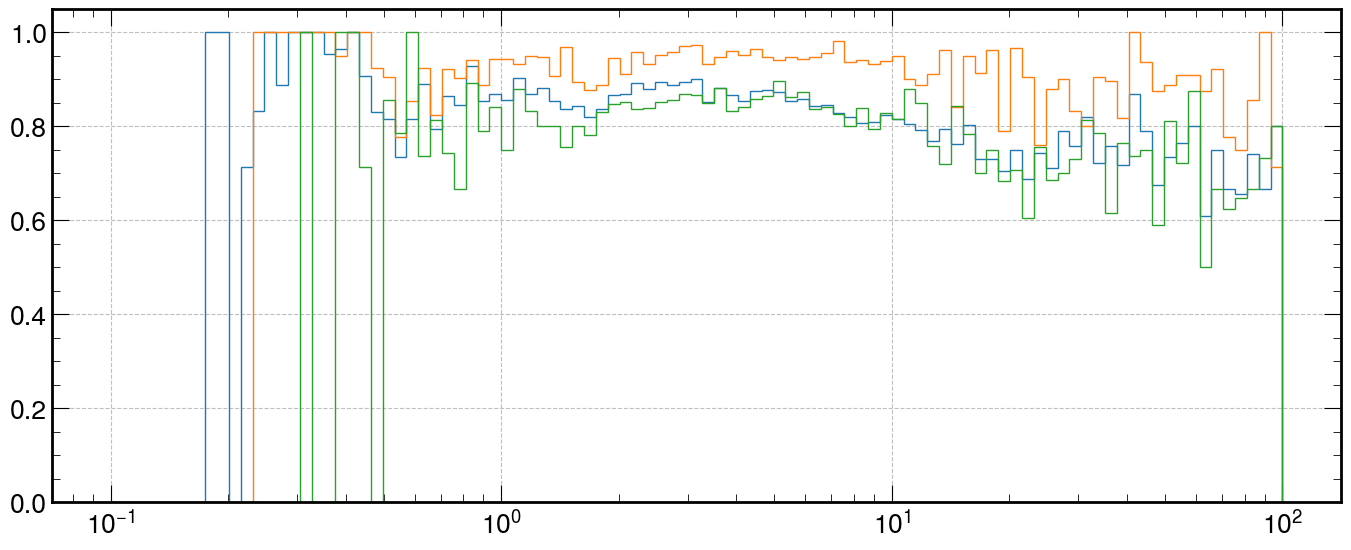

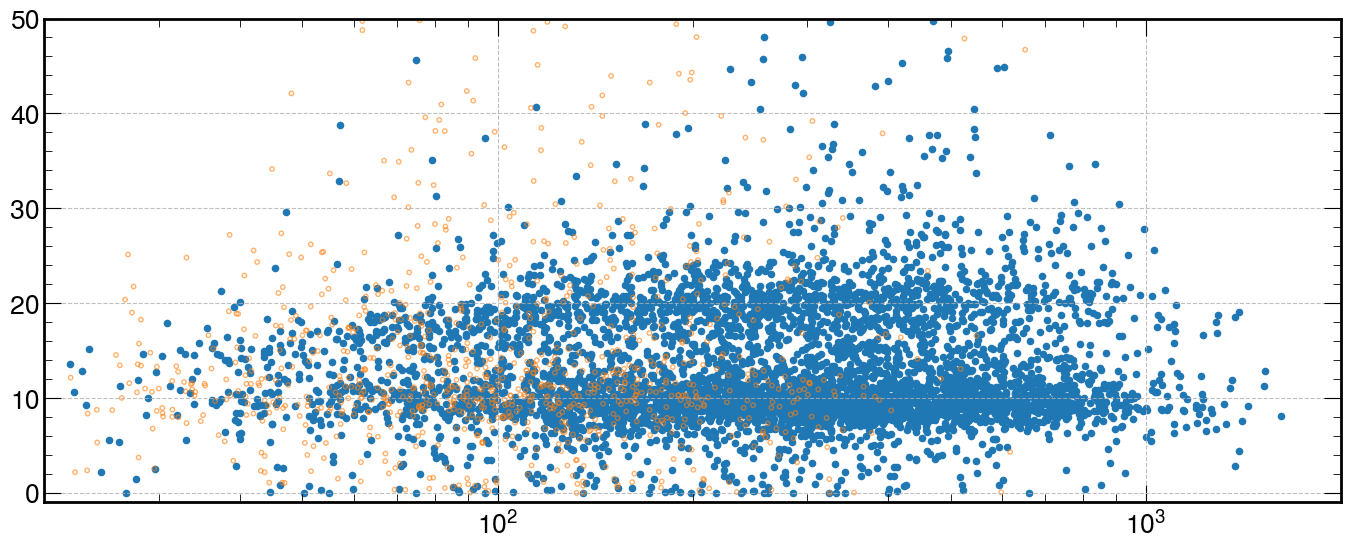

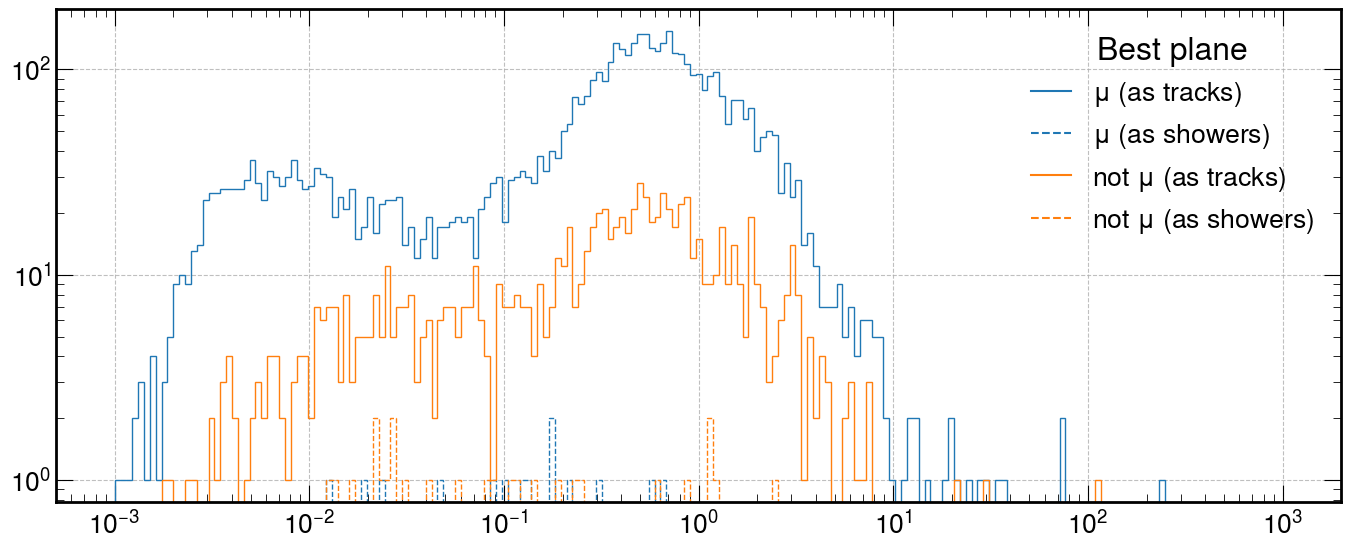

In [1317]:
def get_biggest_dev(df:pl.DataFrame, tailv=[1,2,2]):
    listsort = ['trklen', 'trkmomllhd', 'trkPFPScoreIsTrack', 'overdistvtx']
    listvars = ['biglen', 'bigllhd', 'bigscore', 'bigvtx']
    for _ in listvars[len(tailv):]:
        tailv+=[1]
    df = df.drop(listvars)
    for var, varsort, tt in zip(listvars, listsort, tailv):
        dfsel = df.sort(varsort,).group_by(selection_events(), maintain_order=True).agg(
            pl.col('trkId').tail(tt),
        ).explode(
            'trkId'
        ).with_columns(
            pl.lit(True).alias(var)
        )
        df = df.join(dfsel, on=selection_events('trkId'), how='left', coalesce=True).with_columns(
            pl.col(var).fill_null(False)
        )
    return df
def get_dist_vtx(df:pl.DataFrame):
    
    return df.with_columns(
        (1/(
            (pl.col('trkstartx')- pl.col('recovtxx'))**2 + 
            (pl.col('trkstarty')- pl.col('recovtxy'))**2 + 
            (pl.col('trkstartz')- pl.col('recovtxz'))**2 
        ).sqrt()).alias('overdistvtx'),
    )


dftest, _ = create_mucandidates_2(dfall, fineselection=False)#, calocut=3.5, pidacut=15)
dftest = get_dist_vtx(dftest)
dft2 = dftest.group_by(selection_events(), maintain_order=True).agg(
    pl.len(),
    pl.all(),
).explode(
    pl.all().exclude(selection_events('len'))
).filter(
    pl.col('len')>2,
)
## ------------------------------------------------------------
print('Max purity')
print_ratio(dft2.filter(ismu()), dft2)

dft2 = dft2.filter(
    True,
    pl.col('trklen')>10,
    # pl.col('trkmomllhd') < 4
)

dftotal = dft2.sort('trklen').group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)
plt.figure()
binse = np.logspace(-1,2,100)
# binse = np.logspace(1,4,100)
# binse = np.logspace(-1,1,100)

plot_ratio(dftotal, bins=binse)
plt.xscale('log')
dfismu = dftotal.filter(ismu())
print('This many muons if take longest')
print_ratio(dfismu, dftotal)
## ------------------------------------------------------------ standard

dft2 = get_options(dft2)
dft2 = dft2.with_columns(
    ratioen = pl.col('trklen')*pl.col('trkpartialen_planes_B')/pl.col('trktotalen_planes_B')
)
dft2 = dft2.filter(
    ~((pl.col('trkmomllhd') > 4) & (pl.col('trklen')<50) & pl.col('noptions')>=2)
)
dft2 = get_options(dft2)
dft2 = dft2.filter(
    # pl.col('allcalo_planes_B').is_between(0.3,1e12)
    (pl.col('trkmomllhd')> 2.1*1e-3*pl.col('trklen')+0.005) | (pl.col('noptions')==1),
)
dft2 = get_options(dft2)
dftplot = dft2
dft2 = get_biggest_dev(dft2,[1,1,1,1])
dft2first = dft2.with_columns(
    # pl.when(((pl.col('biglen')) & (pl.col('bigllhd')))).then(True).otherwise(False).alias('selected')
    pl.when(((pl.col('biglen')) & (pl.col('bigllhd')) & (pl.col('trkmomllhd')>0) & (pl.col('bigscore') & (pl.col('bigvtx')) ))).then(True).otherwise(False).alias('selected')
).filter(
    pl.col('selected')
).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)

plot_ratio(dft2first, bins=binse)
plt.xscale('log')

print('First selection')
print_ratio(dft2first.filter(ismu()), dft2first)

## ------------------------------------------------------------ first
dft2 = dft2.join(dft2first, on=selection_events(), how='anti')
print("second round max purity")
print_ratio(dft2.filter(ismu()), dft2)

# dft2 = dft2.filter(
#     # pl.col('allcalo_planes_B').is_between(0.3,1e12)
#     ~(((pl.col('ratioen')>25) | (pl.col('ratioen')<5)) & (pl.col('trklen')<200))
#     # ~(((pl.col('ratioen')>25) | (pl.col('ratioen')<5)) & (pl.col('trklen')<200))
# )
dft2 = get_biggest_dev(dft2, [1,3,3,2])

dft2 = get_options(dft2)
dft2second = dft2.with_columns(
    # pl.when(((pl.col('biglen')) & (pl.col('bigllhd')))).then(True).otherwise(False).alias('selected')
    # pl.when(((pl.col('biglen')) & (pl.col('bigllhd')) & (pl.col('trkmomllhd')>0)) | (pl.col('noptions')<=2)).then(True).otherwise(False).alias('selected')
    pl.when(((pl.col('biglen')) & (pl.col('bigllhd')) & (pl.col('trkmomllhd')>0) & (pl.col('bigscore')) & (pl.col('bigvtx')))).then(True).otherwise(False).alias('selected')
).filter(
    pl.col('selected')
).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)

plot_ratio(dft2second, bins=binse)
plt.xscale('log')
print('Second selection')
print_ratio(dft2second.filter(ismu()), dft2second)

## ------------------------------------------------------------ second
dfout = pl.concat([dft2first, dft2second], how='vertical')
print('Final... ')
print_ratio(dfout.filter(ismu()), dfout)


# dft2 = dft2.filter(((pl.col('biglen'))))
plt.figure()
dftplot = get_biggest_dev(dft2, [1,2,2])
dftplot = get_options(dftplot)
# dftplot = dftplot.filter(
#     # ~(pl.col('biglen')) & (pl.col('bigllhd') & (pl.col('trkmomllhd')>0))
#     ((pl.col('trkmomllhd')>0)),
#     (pl.col('trkmomllhd')> 2.3*1e-3*pl.col('trklen')-0.04)
# )
# plt.scatter(dftplot.filter(ismu())['trklen'], dftplot.filter(ismu())['trkmomllhd'])
dftplot2 = dftplot.with_columns(
    pl.when(
    # ((pl.col('biglen')) & (pl.col('bigllhd')) & (pl.col('trkmomllhd')>0)),
    # (((pl.col('biglen')) & (pl.col('bigllhd')) & (pl.col('trkmomllhd')>0)) | (pl.col('noptions')<=2))
    (((pl.col('biglen')) & (pl.col('bigllhd')) & (pl.col('trkmomllhd')>0) & (pl.col('bigscore'))))
    # ( (pl.col('noptions')<=2))
    # ((pl.col('biglen')) & (pl.col('trkmomllhd')>0))
    ).then(True).otherwise(False).alias('selected')
).filter(
    pl.col('selected')
# ).sort('trklen').group_by(selection_events()).agg(
#     pl.all().last()
)
plt.scatter(dftplot2.filter(ismu())['trklen'], dftplot2.filter(ismu())['ratioen'], s=20)
plt.scatter(dftplot2.filter(~ismu())['trklen'], dftplot2.filter(~ismu())['ratioen'], alpha=0.6, s=10, edgecolors='C1', facecolor='none')
plt.ylim(-1,50)
plt.xlim(20,2e3)
plt.xscale('log')



# a=2.1/1000
# b=-0.005
# plt.plot([20,2000], [20*a-b,a*2000-b], c='k')
# plt.scatter(dftplot2.filter(ismu())['trklen'], dftplot2.filter(ismu())['trkmomllhd'], s=20)
# plt.scatter(dftplot2.filter(~ismu())['trklen'], dftplot2.filter(~ismu())['trkmomllhd'], alpha=0.8, s=10, edgecolors='C1', facecolor='none')
# plt.xscale('log')
# plt.yscale('log')

def operation(df):
    return df['overdistvtx']
    # return df['trkPFPScoreIsTrack']
plt.figure()
binstf = np.linspace(-0.5,1.5,5)
binsdst = np.logspace(-3,3,200)
bins = 200
plot_pid(dftplot2, actual_variable=operation, binspid = binsdst, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, label=' (as tracks)', ShowersAndTracks=False)
plot_pid(dftplot2, actual_variable=operation, binspid = binsdst, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, label=' (as showers)', ls='--', color="C0", ShowersAndTracks=True, onlyShower=True)
plot_pid(dftplot2, actual_variable=operation, binspid = binsdst, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, notthispdg=True, label=' (as tracks)', ShowersAndTracks=False)
plot_pid(dftplot2, actual_variable=operation, binspid = binsdst, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, notthispdg=True, label=' (as showers)', ls='--', color="C1", ShowersAndTracks=True, onlyShower=True)
plt.xscale('log')

plt.yscale('log')

dftplot2.filter(pl.col('noptions')>=2).sort((13-pl.col('trkg4pdg_planes_B').abs()).abs()).group_by(selection_events(), maintain_order=True).agg(
    pl.all()
).select(
    pl.col('run'), pl.col('subrun'), pl.col('event'), pl.col('noptions'),
    pl.col('biglen'), 
    pl.col('bigllhd'), 
    pl.col('bigscore'), 
    pl.col('^trk[^_]*$'),
    pl.col('^.*_B$')
)


Max purity
6820 6820 1.0
This many muons if take longest
4958 6820 0.7269794721407624
This many muons if take longest
4599 4844 0.9494219653179191
second round max purity
1949 1960 0.9943877551020408
Second selection
918 1960 0.4683673469387755
Final... 
5517 6804 0.8108465608465608


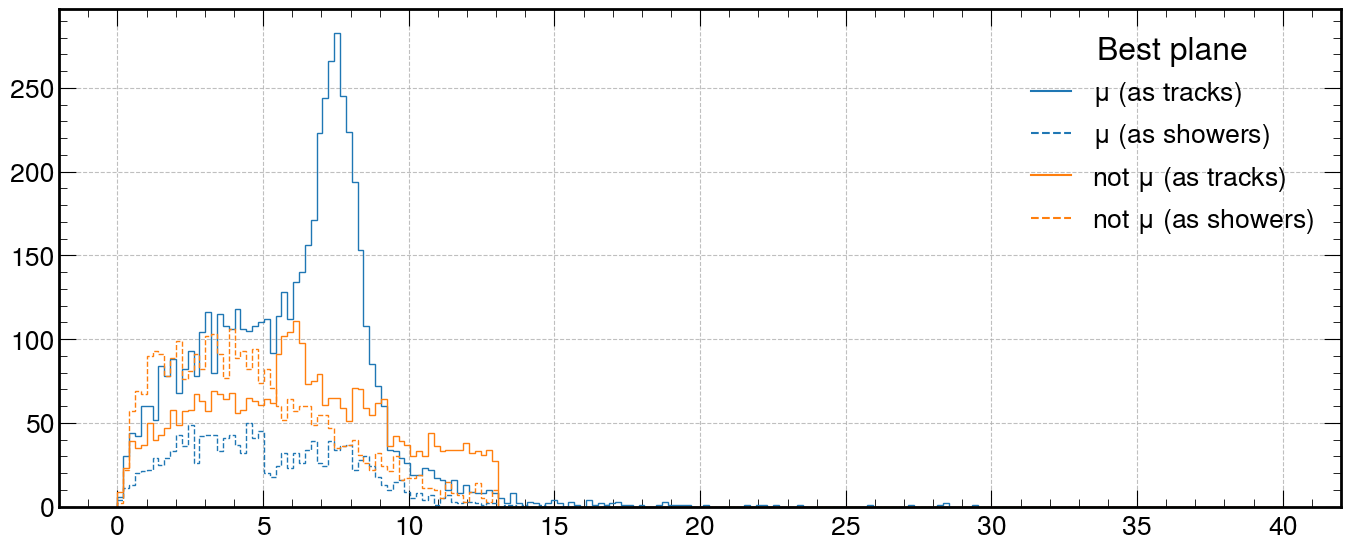

<Figure size 1400x600 with 0 Axes>

In [1382]:
dftest, _ = create_mucandidates_2(dfall, fineselection=True)#, calocut=3.5, pidacut=15)

dft2 = dftest.group_by(selection_events(), maintain_order=True).agg(
    pl.col('selected').any(),
    pl.col('candidate').any()
).filter(~(pl.col('selected'))).drop('selected','candidate')
dft2 = dftest.join(dft2, on=selection_events(), how='inner')

print('Max purity')
print_ratio(dft2.filter(ismu()), dft2)

# def genf(df):
#     df = df.group_by(selection_events()).agg(
#         (pl.col('trkg4pdg_planes_B').abs() == 13).any().alias('hasmu'),
#         pl.all().last()
#     )
#     return df
# def thef(df):
#     return df.filter(pl.col('hasmu'))
# plot_ratio(dft2, bins=binse, var='enu_truth', general_filter=genf, thefilter=thef)
# plot_ratio(dft2, bins=binse, var='allcalo_planes_B', plotnevents=True,  general_filter=genf, thefilter=thef)
# plt.xscale('log')
dftotal = dft2.sort('trklen').group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)
dfismu = dftotal.filter(ismu())
print('This many muons if take longest')
print_ratio(dfismu, dftotal)
## ------------------------------------------------------------ standard

dft2 = get_dist_vtx(dft2)
dft2 = get_options(dft2)
dft2 = dft2.filter(~((pl.col('trkpidpida_B')>=13) & (pl.col('noptions')>1)))
dft2 = get_options(dft2)
dft2 = get_biggest_dev(dft2, [1,1,1,1])
dft2 = dft2.with_columns(
    ratioen = pl.col('trklen')*pl.col('trkpartialen_planes_B')/pl.col('trktotalen_planes_B')
)

def operation(df):
    return df['trkpidpida_B']

plot_pid(dft2, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, label=' (as tracks)', ShowersAndTracks=False)
plot_pid(dft2, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, label=' (as showers)', ls='--', color="C0", ShowersAndTracks=True, onlyShower=True)
plot_pid(dft2, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, notthispdg=True, label=' (as tracks)', ShowersAndTracks=False)
plot_pid(dft2, onlyselected=False, onlycontained=False, threshold_pnc=0., pdg=13, notthispdg=True, label=' (as showers)', ls='--', color="C1", ShowersAndTracks=True, onlyShower=True)
# plt.xscale('log')



dft2first = dft2.with_columns(
    pl.when(((pl.col('biglen')) & (pl.col('bigscore')) )).then(True).otherwise(False).alias('selected')
).filter(
    pl.col('selected')
).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)

print('This many muons if take longest')
print_ratio(dft2first.filter(ismu()), dft2first)
## ------------------------------------------------------------ first

dft2 = dft2.join(dft2first, on=selection_events(), how='anti')
print("second round max purity")
print_ratio(dft2.filter(ismu()), dft2)

dft2 = get_biggest_dev(dft2, [1,2,2,2])

dft2 = get_options(dft2)
dft2second = dft2.with_columns(
    pl.when(((pl.col('biglen'))  )).then(True).otherwise(False).alias('selected')
).filter(
    pl.col('selected')
).sort('trklen').group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)

plt.figure()
print('Second selection')
print_ratio(dft2second.filter(ismu()), dft2second)

dfout = pl.concat([dft2first.select(selection_events('trkg4pdg_planes_B')), dft2second.select(selection_events('trkg4pdg_planes_B'))], how='vertical')
print('Final... ')
print_ratio(dfout.filter(ismu()), dfout)


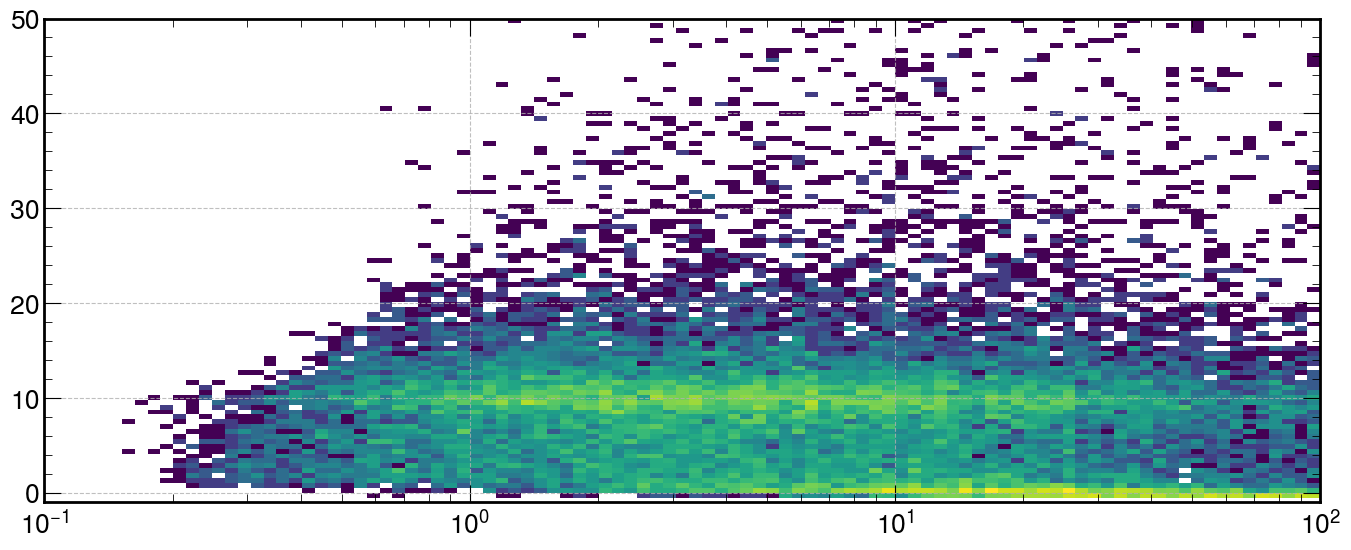

In [801]:
themu = dfall.sort('pnc').filter(
    ~(pl.col('trkg4pdg_planes_B').abs() == 13),
    # pl.col('trklen')>100
# ).group_by(selection_events()).agg(
#     pl.all().last()
).with_columns(
    ratioen = pl.col('trklen')*pl.col('trkpartialen_planes_B')/pl.col('trktotalen_planes_B')
).filter(
    ~pl.col('trkIsContained')
)
binslen = np.logspace(1,np.log10(1.7e3),100)
binsllhd = np.logspace(-1,1,100)
binsr = np.linspace(-1,50,100)
plt.hist2d(themu['enu_truth'], themu['ratioen'], bins=[binse, binsr], norm='log')
plt.xscale('log')
# plt.yscale('log')

In [816]:
dft = dftest.group_by(selection_events()).agg(
    pl.col('trkIsContained2').all().alias('allcontained'),
    pl.all()
).explode(pl.all().exclude(selection_events('allcontained')))
dft = dft.with_columns(
    pnc = pl.col('trkpurity_planes_B')*pl.col('trkcompleteness_planes_B')
).filter(
    # pl.col('trkg4pdg_planes_B').abs()==13,
    pl.col('trkPFPIsTrack')
).sort('trklen').group_by(selection_events()).agg(
    pl.all().last()
)

dft = dft.sort('allcontained')
fig = go.Figure()
fig.add_trace(go.Histogram(x=dft.filter(pl.col('trkg4pdg_planes_B').abs()==13)['allcontained'], name='mu'))
fig.add_trace(go.Histogram(x=dft.filter(pl.col('trkg4pdg_planes_B').abs()!=13)['allcontained'], name='not mu'))

# plot_pid(dft, "B", threshold_pnc=0., pdg=13, label=' (as tracks)', ShowersAndTracks=False)
# plot_pid(dft, "B", threshold_pnc=0., pdg=13, label=' (as showers)', ls='--', color="C0", ShowersAndTracks=True, onlyShower=True)
# plot_pid(dft, "B", threshold_pnc=0., pdg=13, notthispdg=True, label=' (as tracks)', ShowersAndTracks=False)
# plot_pid(dft, "B", threshold_pnc=0., pdg=13, notthispdg=True, label=' (as showers)', ls='--', color="C1", ShowersAndTracks=True, onlyShower=True)
# plt.xlim(0,15)
# plt.figure()
# plt.hist2d(dft['enu_truth'], dft['trkcalo_planes_B'], bins=binse, norm='log', cmap="Reds");
# plt.axhline(4, ls="--", color='k', lw=1)
# plt.yscale('log')
# plt.xscale('log')
# plt.figure()
# plt.hist2d(dft['enu_truth'], dft['trkmomrange_mu'], bins=binse, norm='log', cmap="Reds");
# plt.yscale('log')
# plt.xscale('log')
